In [1]:
!pip install kaggle --upgrade

import os
os.environ['KAGGLE_USERNAME'] = 'hardm00n'
os.environ['KAGGLE_KEY'] = '705411ac0f42b6a6e137b07cfb0b188e'

!kaggle competitions download -c titanic
#!unzip '*.zip'  # 타이타닉 데이터셋은 압축되어 있지 않다. 

train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
!ls

gender_submission.csv  sample_data  StackingSubmission.csv  test.csv  train.csv


## Introduction
이 노트북은 기본 학습 모델의 앙상블(결합)하는 방법에 대해, 특히 Stacking으로 알려진 앙상블의 변형에 대한 매우 기본적이고 간단한 입문서다. 간단히 말해, 몇 가지 기본 분류기의 예측은 첫 번째 수준의 예측으로 사용하고, 두 번째 수준의 다른 모델을 사용해 이전 첫 번째 수준의 예측의 결과를 예측한다.  

타이타닉 데이터셋은 캐글의 많은 초보들이 이 개념을 도입할 수 있는 가장 유력한 후보다. 더군다나 Stacking은 많은 팀이 캐글 대회에서 우승하는데 기여했지만, 이 주제에 대한 커널이 부족한 것 같으니 이 노트북이 어느 정도 그 공백을 메우기를 바란다.  

나 또한 캐글 씬을 처음 접하는 사람이고 우연히 알게된 첫 번째 앙상블 / 스택 스크립트는 위대한 Faron이 AllState Severity Claims 대회에서 쓴 것이다. 이 노트북의 자료는 Faron의 스크립트에서 상당히 차용되었지만, Faron이 회귀 모델들의 앙상블일 때 분류기의 앙상블을 고려하기 위한 포석이었다. 어쨌든 여기서 그의 스크립트를 확인하자. 

[Stacking Starter](https://www.kaggle.com/mmueller/allstate-claims-severity/stacking-starter/run/390867) : by Faron  

이제 노트북에 올려놓고 그것이 정의를 실천하고 앙상블의 개념을 직관적이고 간결하게 전달해주길 바란다. 아래에는 논의한 것과 동일한 앙상블 단계를 구현하는 다른 독립형 캐글 스크립트는 Public LB 점수가 0.808로 상위 9%에 도달하기에 충분하며 4분 이내에 실행된다. 따라서 나는 그 스크립트에 추가하고 개선할 여지가 많다고 생각한다. 어쨌든 어떻게 하면 좋을지 자유롭게 댓글을 남겨달라. 

In [3]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import re  # regex(정규표현식)
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plotly : 시각화 라이브러리, 그래프가 타 라이브러리에 비해 아름답다.
import plotly.offline as py 
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# stacking을 위해 아래 5가지 기본 모델을 사용할 것이다. 
from sklearn.ensemble import(RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
# from sklearn.cross_validation import KFold -> model_selection으로 바뀌었다. 
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

이제 우리는 일반적으로 대부분의 커널이 구조화되는 방식과 매우 비슷하게 진행할 것이다. 즉, 먼저 현재 데이터를 탐색하고 가능한 Feature Engineering 기회를 식별해 범주형 Feature를 수치적으로 인코딩한다. 

In [4]:
# train, test 데이터셋 로드
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# 쉬운 접근을 위해 PassengerId를 따로 저장
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


우리의 태스크는 범주형 변수에서 어떻게든 정보를 추출하는 것이다.  

### Feature Engineering

여기에, Feature Engineering 아이디어를 위한 Sina의 잘 숙고된 노트북에 대한 Credit이 확장되어야 한다. 그의 작품들을 확인해봐라. 

[Titanic Best Working Classfier](https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier) : by Sina

In [5]:
full_data = [train, test]

# 추가한 feature 중 일부
# name의 길이를 나타내는 feature
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# 타이타닉에 탑승한 승객이 객실을 갖고 있었는지에 대해 알려주는 feature
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

# Sina에게서 가져온 Feature Engineering 단계
# SibSp와 Parch를 조합해 FamilySize라는 새 feature를 생성
for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# FamilySize로부터 IsAlone이라는 새 feature 생성
for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Embarked의 결측치 처리
for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Fare의 결측치 처리 및 CategoricalFare라는 새 feature 생성
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())  # 중앙값으로 대체
# qcut : 동일한 개수로 구간을 나눔, cut : 동일한 길이로 구간을 나눔
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# CategoricalAge라는 새 feature 생성
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# 승객의 name에서 title을 추출하는 함수 정의
def get_title(name):
  title_search = re.search(' ([A-Za-z]+)\.', name)
  # 만약 title이 존재한다면, 추출해서 반환
  if title_search:
    return title_search.group(1)
  return ""
# 승객 name의 title을 나타내는 Title이라는 새 feature 생성
for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)
# non-common한 title들을 하나의 'Rare'로 그룹화
for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
  # Mapping Sex
  dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int)

  # Mapping titles
  title_mapping = {"Mr":1, "Miss":2, "Mrs":3, "Master":4, "Rare":5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

  # Mapping Embarked
  dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

  # Mapping Fare
  dataset.loc[dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)

  # Mapping Age
  dataset.loc[dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[dataset['Age'] > 64, 'Age'] = 4


In [6]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)  # 왜 굳이 만들었다가 지우는건지 의문이다. 
test = test.drop(drop_elements, axis=1)

이제 feature를 정리하고 관련된 정보들을 추출하고 범주형 열을 삭제했기에 feature는 모두 수치형이어야 하며, 이는 기계 학습 모델에 제공하기에 적합한 형식이다. 그러나 계속하기 전에 변환된 데이터셋의 간단한 상관 관계 및 분포도를 만들어보자.  

## Visualizations

In [7]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


### Pearson Correlation Heatmap
한 feature가 다음 feature와 어떤 관련이 있는지 확인하기 위해 feature에 대한 몇 가지 상관 plot을 생성해보자. 이를 위해 우리는 히트맵을 다음과 같이 매우 편리하게 plot할 수 있는 Seaborn plot 패키지를 활용할 것이다. 

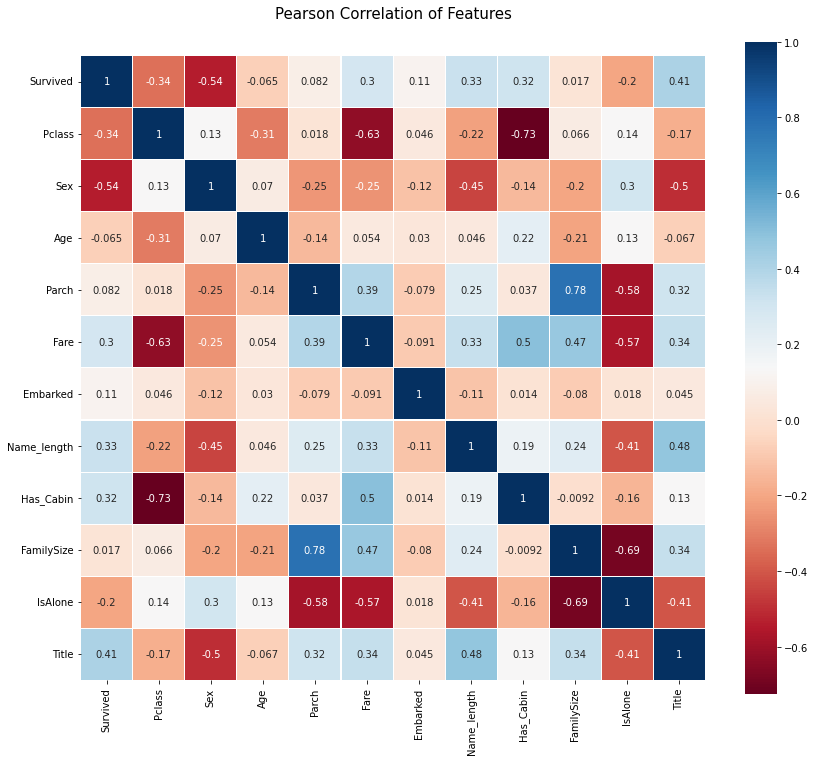

In [8]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidth=0.1,  # linewidth : 히트맵 블록 사이 경계선
            vmax=1.0, square=True, cmap=colormap,  # vmax : 색으로 표현하는 최대값, square : 차트를 정사각형으로 할 것인지
            linecolor='white', annot=True)  # annot : 블록의 숫자 표시

### Takeaway from the Plots
Pearson 상관 그림을 통해 서로 강하게 연관된 특징이 너무 많지 않다는 것을 알 수 있다. 이는 train 데이터셋에 중복되거나 불필요한 데이터가 많지 않고 각 feature에 고유한 정보가 제공되므로 학습 모델에 이러한 feature를 제공하는 것이 좋다. FamilySize와 Parch(부모와 자식)가 상관 관계가 가장 높은 두 가지 feature다. 이 연습의 목적을 위해 두 가지 feature를 모두 사용할 것이다.  

### Pairplots
마지막으로 한 feature에서 다른 feature로의 데이터 분포를 관찰하기 위한 몇 가지 pairplot을 생성해보자. 다시 한 번 우리는 우리를 돕기 위해 Seaborn을 사용한다. 

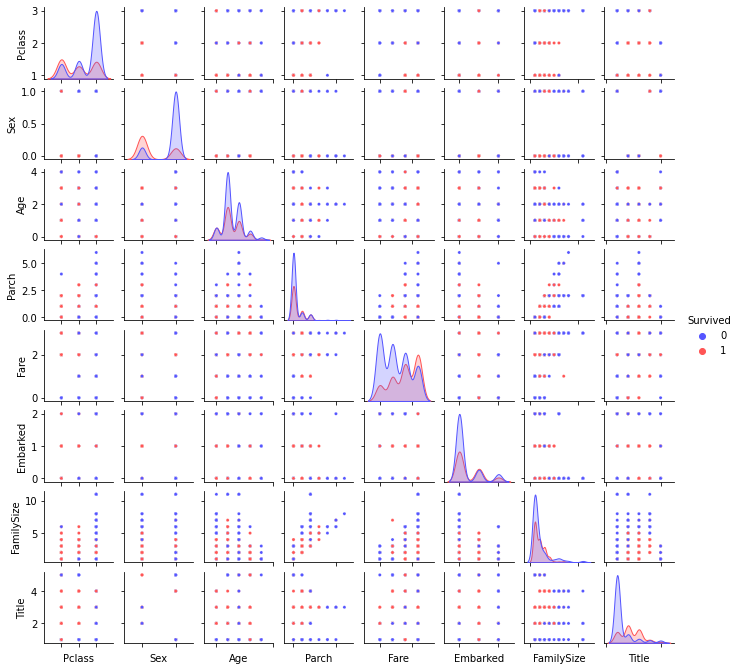

In [9]:
# pairplot : 인자로 전달되는 데이터프레임의 열(변수)을 두 개씩 짝 지을 수 있는 모든 조합에 대해서 표현
# 같은 변수끼리 짝을 이루는 대각선 방향으로는 히스토그램을 그린다. 
# 서로 다른 변수 간에는 산점도를 그린다. 
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age',  # 뭔가 유니코드로 바꾸는 것 같은데 이유는 잘 모르겠다.
                       u'Parch', u'Fare', u'Embarked',
                       u'FamilySize', u'Title']], hue='Survived', palette='seismic',
                 size=1.2, diag_kind='kde', diag_kws=dict(shade=True),  # diag_kind='kde' -> 각 변수별 커널밀도추정곡선
                 plot_kws=dict(s=10))  # 키워드 인수 사전을 plot_kws는 이변량 플로팅 함수에 전달되고, 
                 # diag_kws는 일변량 플로팅 함수에 전달되고, grid_kws는 PairGrid 생성자에 전달된다고 한다.  
g.set(xticklabels=[])

## Ensembling & Stacking models
Feature Engineering과 formatting에 관한 짧은 회오리바람이 지나간 후, 마침내 이 노트북의 핵심과 요지에 도달했다.  
Stackinig 앙상블을 만들자!  

### Helpers via Python Classes
여기서는 파이썬의 클래스 사용을 호출해 보다 편리하게 만들 수 있다. 프로그래밍을 처음 접하는 사람들은 보통 클래스가 OOP(Object-Oriented Programming)와 함께 사용되는 것을 듣는다. 즉, 클래스는 객체를 만들기 위한 일부 코드/프로그램의 확장일 뿐 아니라 해당 클래스에 특화된 함수 및 메소드를 구현하는데 도움이 된다.  

아래 코드 섹션에서는 기본적으로 모든 sklearn 분류기에 공통되는 내장 메서드(train, predict, fit)를 확장할 수 있는 클래스 SklearnHelper를 작성한다. 따라서 5개의 다른 분류기를 호출하고자 할 때 동일한 메서드를 5번 쓸 필요가 없기 때문에 중복성을 차단한다. 

In [10]:
# 나중에 유용하게 사용할 수 있는 몇 가지 파라미터
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0  # 나중에 재현하기 위해
NFOLDS = 5  # out-of-fold prediction을 위해 folds 설정
#kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED) -> deprecation
kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

# Sklearn classifier를 확장하기 위한 클래스
class SklearnHelper(object):
  def __init__(self, clf, seed=0, params=None):
    params['random_state'] = seed
    self.clf = clf(**params)

  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)

  def predict(self, x):
    return self.clf.predict(x)

  def fit(self, x, y):
    return self.clf.fit(x, y)

  def feature_importances(self, x, y):
    print(self.clf.fit(x, y).feature_importances_)

# XGboost classifier의 확장을 위한 클래스 -> ???

이미 알고 있겠지만 파이썬에서 클래스나 객체를 만들어 본 적이 없는 분들을 위해 위에 주어진 코드가 무엇을 하는지 설명하겠다. 기본 분류기를 만들 때, 나는 Sklearn 라이브러리에 이미 있는 모델만 사용할 것이며 따라서 클래스를 확장할 것이다.  
**def init** : 클래스에 대한 기본 생성자를 호출하기 위한 파이썬 표준이다. 즉, 객체(분류기)를 만들려면 clf(원하는 sklearn 분류기), 시드(랜덤 시드), 파라미터(분류기 매개 변수)의 매개 변수를 제공해야 한다.  
코드의 나머지는 단순히 sklearn 분류기에 이미 존재하는 해당 메서드를 호출하는 클래스의 메서드다. 본질적으로, 우리는 다양한 sklearn 분류기를 확장하기 위해 wrapper 클래스를 만들어 여러 모델을 stacker에 구현할 때 동일한 코드를 반복 작성해야하는 것을 줄였다.  


### Out-of-Fold Predictions
이제 도입부에서 언급한 바와 같이, 스택은 두 번째 수준 모델에 대한 훈련을 위한 입력으로 기본 분류기의 에측을 사용한다. 그러나 단순히 전체 훈련 데이터에 대한 기본 모델을 훈련하고 전체 테스트 세트에 대한 예측을 생성한 다음 2차 훈련을 위해 이를 출력할 수는 없다. 이렇게 하면 기본 모형 예측이 검정 집합을 이미 "봐서" 이러한 예측을 제공할 때 과적합될 위험이 있다. 

In [11]:
def get_oof(clf, x_train, y_train, x_test):
  oof_train = np.zeros((ntrain, ))
  oof_test = np.zeros((ntest, ))
  oof_test_skf = np.empty((NFOLDS, ntest))

  # for i, (train_index, test_index) in enumerate(kf): -> 역시 sklearn 버전 문제로 아래와 같이 수정
  for i, (train_index, test_index) in enumerate(kf.split(train)):
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[test_index]

    clf.train(x_tr, y_tr)

    oof_train[test_index] = clf.predict(x_te)
    oof_test_skf[i, :] = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0)
  return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generating our Base First-Level Models
그럼 이제 첫 번째 레벨 분류로 다섯 가지 학습 모델을 준비하자. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열되어 있다. 
1. Random Forest classifier
2. Extra Trees classifier
3. AdaBoost classifier
4. Gradient Boosting classifier
5. Support Vector Machine  



### Parameters
완성도를 위해 여기에 나열할 변수들을 간단히 요약해보자. 
- n_jobs : 훈련 프로세스에 사용되는 코어 수다. -1로 설정하면 모든 코어가 사용된다. 
- n_estimators : 학습 모델의 분류 트리 수(default=10)
- max_depth : 트리의 최대 깊이 또는 노드를 확장할 크기. 너무 높게 설정하면 나무가 너무 깊게 자라 과적합될 위험이 있으니 주의하자. 
- verbose : 학습 프로세스 중 텍스트를 출력할지 여부를 제어한다. 0은 모든 텍스트를 억제하고 3은 반복할 때마다 트리 학습 프로세스를 출력한다.  

자세한 설명은 sklearn 공식 홈페이지를 통해 확인하자. 거기서 여러분이 갖고 놀 수 있는 많은 다른 파라미터들을 발견할 수 있을 것이다. 

In [12]:
# 해당 분류기에 대한 파라미터 입력
# 랜덤 포레스트 파라미터
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    # 'max_features': 0.2, 
    'max_depth': 6, 
    'min_samples_leaf': 2,
    'max_features': 'sqrt',  # 최대 선택할 feature의 수
    'verbose': 0
}

# Extra Trees 파라미터
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    # 'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,  # leaf 노드에 있어야 하는 최소 샘플 수, 이는 특히 회귀에서 모형을 부드럽게 하는 효과가 있다고 한다. 흠...
    'verbose': 0
}

# AdaBoost 파라미터
ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

# Gradient Boosting 파라미터
gb_params = {
    'n_estimators': 500,
    # 'max_features': 0.2, 
    'max_depth': 5, 
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier 파라미터
svc_params = {
    'kernel': 'linear',
    'C': 0.025  # 얼마나 많은 데이터 샘플이 다른 클래스에 놓이는 것을 허용하는지 결정(default=1)
} 

또한, OOP 프레임워크 내의 객체와 클래스에 대해 언급했기에 앞에서 정의한 Helper Sklearn 클래스를 통해 5가지 학습 모델을 나타내는 5가지 객체를 생성해보자.

In [13]:
# 5가지 학습 모델을 나타내는 5개의 객체 생성
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

### Creating Numpy arrays out of our train and test sets
좋다. 이렇게 첫 번째 레이어 기본 모델을 준비했으므로 이제 NumPy 어레이를 원래 데이터 프레임에서 생성해 분류기에 입력하기 위한 훈련 및 테스트 데이터를 다음과 같이 준비할 수 있다. 

In [14]:
# 우리의 모델에 입력하기 위한 train, test, target(Survived)의 Numpy array 생성
y_train = train['Survived'].ravel()  # 1차원으로 풀어준다
train = train.drop(['Survived'], axis=1)
x_train = train.values  # train data 배열 생성
x_test = test.values  # test data 배열 생성

### Output of the First level Predictions
이제 훈련 및 테스트 데이터를 5개의 기본 분류기에 공급하고 앞에서 정의한 Out-of-Fold 예측 함수를 사용해 첫 번째 수준 예측을 생성한다. 아래 코드 덩어리가 실행될 때까지 몇 분 기다린다. 

In [15]:
# OOF train과 test 예측을 생성. 이 기본 결과들은 새로운 feature로 사용될 것이다. 
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)  # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)  # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)  # AdaBoost
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)  # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)  # Support Vector Classifier

print("Training is complete")

Training is complete


### Feature importances generated from the different classifiers
이제 첫 번째 레벨 분류기를 학습했으므로 Sklearn 모델의 매우 중요한 기능을 활용할 수 있다. 즉, 매우 간단한 코드 한 줄로 훈련 및 테스트 세트의 다양한 기능의 중요성을 출력하는 것이다.  
Sklearn 설명서에 따르면 대부분의 분류기는 .featureimports를 입력하기만 하면 feature importances를 반환하는 속성이 내장되어 있다. 따라서 우리는 함수 접지(?)를 통해 이 매우 유용한 속성을 호출하고 feature importances를 plot할 것이다. 

In [16]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.10572691 0.20891106 0.03591783 0.02007832 0.04710247 0.02781424
 0.12844431 0.04794971 0.07103486 0.01197641 0.29504389]
[0.11822778 0.37617675 0.02742865 0.0169153  0.05618426 0.02965192
 0.04700138 0.08491733 0.0445713  0.02174624 0.17717909]
[0.03  0.01  0.018 0.064 0.036 0.01  0.696 0.012 0.054 0.002 0.068]
[0.08645297 0.01158581 0.04509841 0.01154424 0.05002764 0.0265051
 0.17133029 0.03688132 0.11543205 0.00626672 0.43887544]


그래서 feature importances를 어떻게 할당하고 저장해야할지 아직 파악하지 못했다. 그러므로 위의 코드 값을 출력한 후 아래와 같이 파이썬 list에 복사해 붙여넣을 것이다. (저조한 해킹에 대해 사과한다)

In [17]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

plotly 패키지를 쉽게 plot할 수 있도록 feature importances가 포함된 list에서 데이터프레임을 작성한다. 

In [18]:
cols = train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame({'features':cols,
                                  'Random Forest feature importances': rf_features,
                                  'Extra Trees feature importances': et_features,
                                  'AdaBoost feature importances': ada_features,
                                  'Gradient Boost feature importances': gb_features})

### Interactive feature importances via Plotly scatterplots
이 시점에서 대화형 Plotly 패키지를 사용해 다음과 같이 산점도를 호출해 플롯 산점도를 통해 여러 분류기의 feature importance 값을 시각화해보자. 

In [19]:
# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',  # 입력하지 않으면 기본 선 그래프가 출력
    marker=dict(  # Plotly는 그래프를 커스터마이즈 할 수 있는 다양한 기능을 제공한다. 여기서는 마커의 서식을 바꾼다.  
        sizemode = 'diameter',  # 지름, 자세한 것은 https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter.html 참조
        sizeref = 1,  # sizemode와 함께 사용
        size = 25,
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500), # set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,  # 색깔 값을 DataFrame의 values에 따라 변하도록 설정
        colorscale='Portland',  # plotly colorscale 중 하나
        showscale=True  # colorscales 옆에다가 보여줌
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest',  # # 커서에 가까운 점에 대한 hover 레이블이 나타난다. 
    # xaxis = dict{
        # title='Pop',
        # ticklen=5,
        # zeroline=False,
        # gridwidth=2,
    # },
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')
fig.show(renderer="colab")

# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Extra Trees feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500), # set color equal to a variable
        color = feature_dataframe['Extra Trees feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='ExtraTrees Feature Importance',
    hovermode='closest',
    # xaxis = dict{
        # title='Pop',
        # ticklen=5,
        # zeroline=False,
        # gridwidth=2,
    # },
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')
fig.show(renderer="colab")

# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500), # set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermode='closest',
    # xaxis = dict{
        # title='Pop',
        # ticklen=5,
        # zeroline=False,
        # gridwidth=2,
    # },
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')
fig.show(renderer="colab")

# Scatter plot
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        # size = feature_dataframe['AdaBoost feature importances'].values,
        # color = np.random.randn(500), # set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout = go.Layout(
    autosize=True,
    title='Gradient Boosting Feature Importance',
    hovermode='closest',
    # xaxis = dict{
        # title='Pop',
        # ticklen=5,
        # zeroline=False,
        # gridwidth=2,
    # },
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
# py.iplot(fig,filename='scatter2010')
fig.show(renderer="colab")

이제 모든 feature importance의 평균을 계산해 feature importance 데이터프레임에 새로운 열로 저장하자. 

In [20]:
# 평균을 나타내는 새 컬럼 생성
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)  # axis = 1은 행 단위로 평균 계산
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,0.067961,0.080590
1,Sex,0.218370,0.370983,0.008,0.038893,0.159062
2,Age,0.044327,0.031296,0.012,0.072378,0.040000


### Plotly Barplot of Average Feature Importances
모든 분류기에 걸쳐 feature importance의 평균을 얻었으므로 다음과 같이 Plotly 막대 플롯으로 나타낼 수 있다. 

In [21]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x=x,
    y=y,
    width=0.5,
    marker=dict(
        color=feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True,
        reversescale=False  # 색상 스케일이 반전된다.
    ),
    opacity=0.6  # 불투명도
)]

layout = go.Layout(
    autosize=True,
    title='Barplots of Mean Feature Importance',
    hovermode='closest',  # 커서에 가까운 점에 대한 hover 레이블이 나타난다. 
    # xaxis=dict(
        # title='Pop',
        # ticklen=5,
        # zeroline=False,
        # gridwidth=2,
    # ),
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2
    ),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
#py.iplot(fig, filename='bar-direct-labels')
fig.show(renderer="colab")

## Second-Level Predictions from the First-level Output  


### First-level output as new features
이제 첫 번째 수준의 예측을 얻었으므로, 본질적으로 다음 분류기의 훈련 데이터로 사용될 새로운 feature 세트를 구축하는 것이라고 생각할 수 있다. 따라서 아래 코드에 따라, 우린는 새로운 컬럼으로 이전 분류기들의 첫 번째 예측을 갖고 있으며, 이에 대해 다음 분류기로 교육한다. 

In [22]:
base_prediction_train = pd.DataFrame({'RandomForest': rf_oof_train.ravel(),
                                      'ExtraTrees': et_oof_train.ravel(),
                                      'AdaBoost': ada_oof_train.ravel(),
                                      'GradientBoost': gb_oof_train.ravel()
                                      })
base_prediction_train.head()

,RandomForest,ExtraTrees,AdaBoost,GradientBoost
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


### Correlation Heatmap of the Second Level Training set

In [23]:
data = [
        go.Heatmap(
            z=base_prediction_train.astype(float).corr().values,
            x=base_prediction_train.columns.values,
            y=base_prediction_train.columns.values,
            colorscale='Viridis',
            showscale=True,
            reversescale=True
        )
]
# py.iplot(data, filename='labelled-heatmap')
fig = go.Figure(data=data)
fig.show(renderer="colab")

서로 상관관계가 없는 훈련된 모델들이 더 좋은 점수를 만들어낼 수 있다는 장점에 대한 기사들과 캐글 대회 우승자들의 이야기가 꽤 있었다. 

In [24]:
x_train = np.concatenate((et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

이제 첫 번째 수준의 train과 test 예측을 x_train, x_test로 연결 및 결합했으므로, 이제 두 번째 수준의 학습 모델을 학습시킬 수 있다.  


### Second level learning model via XGBoost
여기서 우리는 boosted 트리 학습 모델로 매우 유명한 라이브러리인 XGBoost를 선택한다. 이것은 대규모 부스트 트리 알고리즘을 최적화하기 위해 만들어졌다. 알고리즘에 대한 자세한 내용은 [공식문서](https://xgboost.readthedocs.io/en/latest/)를 참고하라.  

어쨌든, 우리는 XGBClassfier를 호출해 1차 train 및 target 데이터에 맞추고 학습된 모델을 사용해 다음과 같이 테스트 데이터를 예측한다. 

In [25]:
# 각 파라미터에 관한 자세한 설명은 https://injo.tistory.com/44 참조
gbm = xgb.XGBClassifier(
    # learning_rate=0.02,
    n_estimators=2000,
    max_depth=4,  # 트리 기반 알고리즘의 max_depth와 동일, 0으로 설정하면 깊이 제한 없음
    min_child_weight=2,  # GBM의 min_samples_leaf와 유사, 관측치에 대한 가중치 합의 최소를 말한다. (과적합 조절 용도)
    # gamma=1,
    gamma=0.9,  # 리프 노드의 추가 분할을 결정할 최소손실 감소값, 해당값보다 손실이 크게 감소할 때 분리, 값이 클수록 과적합 감소 효과
    subsample=0.8,  # GBM의 subsample과 동일, 데이터 샘플링 비율 지정 (과적합 제어)
    colsample_bytree=0.8,  # 트리 생성에 필요한 피처의 샘플링에 사용, 피처가 많을 때 과적합 조절에 사용
    objective='binary:logistic',  # 학습 태스크 파라미터 : 이진분류를 의미
    nthread=-1,  # CPU 실행 스레드 개수 조정
    scale_pos_weight=1).fit(x_train, y_train)  # scale_pos_weight : 불균형 데이터셋의 균형을 유지
predictions = gbm.predict(x_test)

모델에 사용되는 XGBoost 파라미터를 간단히 살펴보면 다음과 같다.  
- **max_depth** : 트리를 얼마나 깊게 키울지, 너무 높게 설정하면 과적합 위험이 있으므로 주의하라. 
- **gamma** : 트리의 리프 노드에서 추가 파티션을 만드는데 필요한 최소 손실 감소. 크기가 클수록 알고리즘은 더 보수적일 것이다. 
- **eta** : 각 부스팅 단계에서 과적합을 방지하기 위해 단계 크기 축소를 사용함.  


### Producing the Submission file
마지막으로 모든 1단계 및 2단계 모델을 학습한 후 다음과 같이 예측값을 타이타닉 대회에 제출하기 위한 적절한 형식으로 출력할 수 있다. 

In [26]:
# Submission 파일 생성
StackingSubmission = pd.DataFrame({'PassengerId': PassengerId,
                                   'Survived': predictions})
StackingSubmission.to_csv("StackingSubmission.csv", index=False)

### Steps for Further Improvement
마무리 발언으로서, 위에서 취한 단계들은 앙상블 스태커를 생성하는 매우 간단한 방법을 보여준다는 것에 주목해야 한다. 스택형 분류기와 2단계 이상으로 올라가는 스택의 괴물적 조합이 수반되는 가장 높은 수준의 캐글 대회에서 생성된 앙상블에 대해 들을 수 있을 것이다.  

점수를 높이기 위해 취할 수 있는 몇 가지 추가 단계는 다음과 같다. 
1. 최적의 모수 값을 찾기 위해 모델을 학습할 때 우수한 cross-validation 전략 구현
2. 학습을 위해 더 다양한 기본 모델을 소개한다. 상관관계가 없는 결과일수록 최종 점수가 더 좋다.  


### Conclusion
나는 이 노트북이 학습 모델을 쌓는 작업 스크립느를 소개하는데 어느 정도 도움이 되었다고 생각한다. 다시 한 번 Faron 과 Sina에게 그 공을 돌린다. 

일반적으로 스택킹 혹은 앙상블링에 대한 기타 우수한 자료는 MLWave : [Kaggle Ensembling Guide](http://mlwave.com/kaggle-ensembling-guide/)의 사실적 필독 문서를 참조하라.